# Neural Networks in PyTorch
## Part 9: Image Acquisition and Analysis
*Yen Lee Loh, 2022-11-27*

---
## 1. Demonstrate individual image capture from webcam

In [1]:
import imageio as iio
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
camera = iio.get_reader("<video0>")

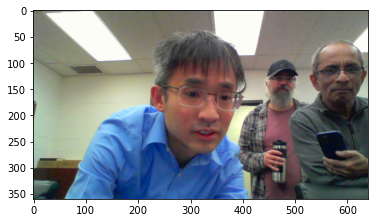

In [3]:
#======== RUN THIS CELL TO TAKE A PICTURE!
frame = camera.get_next_data()
plt.imshow(frame);

In [4]:
camera.close()

---
## 2. Capture a series of frames

In [2]:
def takeSelfies(numImages=60):
  camera = iio.get_reader("<video0>")
  frames = []
  print ("WHEN YOU ARE DONE TAKING SELFIES, TYPE q AND PRESS Enter.")
  for i in range(numImages):
    time.sleep (.1)
    frame = camera.get_next_data()
    frames += [frame]
  camera.close()
  print ("Captured", len(frames), "images!")
  return frames

def showSelfies(frames,imageWidth=2,cols=5,cmap=None): # imageWidth is in inches
  cells = len(frames)
  rows = (cells+cols-1)//cols
  height = frames[0].shape[0]
  width  = frames[0].shape[1]
  aspect = height/width
  plt.figure (figsize=(cols*imageWidth,rows*imageWidth*aspect))
  for i in range(cells):
    plt.subplot (rows,cols,1+i)
    plt.imshow (frames[i], aspect=1, cmap=cmap) ; plt.axis ('off')
  plt.subplots_adjust (0,0,1,1,0,0) # L,B,R,T,hspace,vspace

In [8]:
frames0 = takeSelfies()   

WHEN YOU ARE DONE TAKING SELFIES, TYPE q AND PRESS Enter.
Captured 60 images!


In [ ]:
showSelfies(frames0)

---
## 2. Capture a series of frames

In [7]:
def takeSelfies(numImages=10):
  camera = iio.get_reader("<video0>")
  frames = []
  print ("WHEN YOU ARE DONE TAKING SELFIES, TYPE q AND PRESS Enter.")
  for i in range(numImages):
    #time.sleep (1)  # if you prefer, wait for 1 second instead of waiting for Enter
    cmd = input ("Press Enter to take selfie {}".format(i))
    if cmd=='q':
      break
    frame = camera.get_next_data()
    frames += [frame]
  camera.close()
  print ("Captured", len(frames), "images!")
  return frames

def showSelfies(frames,imageWidth=2,cols=5,cmap=None): # imageWidth is in inches
  cells = len(frames)
  rows = (cells+cols-1)//cols
  height = frames[0].shape[0]
  width  = frames[0].shape[1]
  aspect = height/width
  plt.figure (figsize=(cols*imageWidth,rows*imageWidth*aspect))
  for i in range(cells):
    plt.subplot (rows,cols,1+i)
    plt.imshow (frames[i], aspect=1, cmap=cmap) ; plt.axis ('off')
  plt.subplots_adjust (0,0,1,1,0,0) # L,B,R,T,hspace,vspace

In [8]:
frames0 = takeSelfies()       # TAKE 10 PICTURES OF YOURSELF (SAY)

WHEN YOU ARE DONE TAKING SELFIES, TYPE q AND PRESS Enter.


Press Enter to take selfie 0 
Press Enter to take selfie 1 
Press Enter to take selfie 2 
Press Enter to take selfie 3 
Press Enter to take selfie 4 
Press Enter to take selfie 5 
Press Enter to take selfie 6 
Press Enter to take selfie 7 
Press Enter to take selfie 8 
Press Enter to take selfie 9 


Captured 10 images!


In [9]:
frames1 = takeSelfies()       # TAKE 10 PICTURES OF YOUR FRIEND (SAY)

WHEN YOU ARE DONE TAKING SELFIES, TYPE q AND PRESS Enter.


Press Enter to take selfie 0 
Press Enter to take selfie 1 
Press Enter to take selfie 2 
Press Enter to take selfie 3 
Press Enter to take selfie 4 
Press Enter to take selfie 5 
Press Enter to take selfie 6 
Press Enter to take selfie 7 
Press Enter to take selfie 8 
Press Enter to take selfie 9 


Captured 10 images!


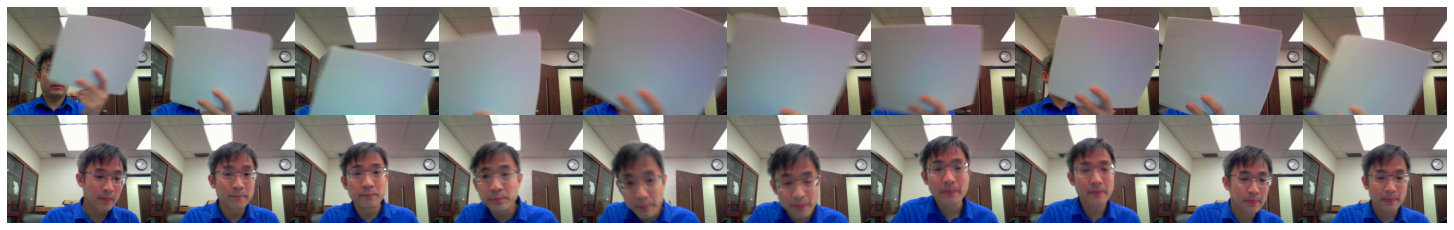

In [10]:
showSelfies (frames0+frames1, cols=10, imageWidth=2)

---
## 3. Preprocess set of images

In [44]:
import torch
from torch import nn

In [45]:
ynd = torch.Tensor (len(frames0)*[0] + len(frames1)*[1]).reshape (-1,1)

In [46]:
xnijk = np.array(frames0 + frames1)   # n=instance, i=row, j=column, k=channel (RGB)
xnijk.shape

(20, 480, 640, 3)

In [47]:
xnijkCropped = xnijk[:,:,80:80+480,:]   # crop to square
xnijkCropped.shape

(20, 480, 480, 3)

In [48]:
xnij = np.mean (xnijkCropped, axis=3)   # average over RGB to get grayscale image
xnij.shape

(20, 480, 480)

In [49]:
downsampler = nn.MaxPool2d(kernel_size=15)
xnij = downsampler (torch.Tensor(xnij))
xnij.shape

torch.Size([20, 32, 32])

In [50]:
xnd = xnij.flatten (1,-1)
xnd.shape

torch.Size([20, 1024])

Automate the above procedure:

In [57]:
def inputTrf(xnijk):
  xnijk = xnijk[:,:,80:80+480,:]   # crop to square
  xnij = np.mean (xnijk, axis=3)   # average over RGB to get grayscale image
  xnij = nn.AvgPool2d(kernel_size=15) (torch.Tensor(xnij)) # downsample 
  xnij = xnij - torch.mean (xnij)
  xnij = xnij / torch.std (xnij)
  #xnij = torch.diff(xnij, dim=1)
  #xnij = torch.diff(xnij, dim=2)
  #xnij = torch.nn.functional.pad(xnij, [0,1,0,1])
  #xnd = xnij.flatten (1,-1)
  return xnij

In [58]:
xnij = inputTrf (xnijk) # make our training data set
xnd = xnij.flatten (1,-1)
xnij.shape

torch.Size([20, 32, 32])

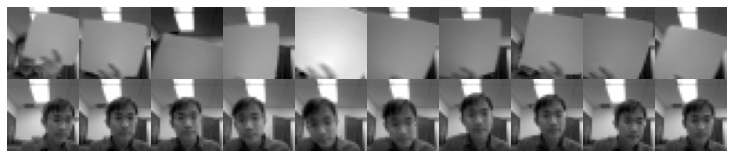

In [59]:
showSelfies(xnij,cmap='gray', cols=10, imageWidth=1)

---
## 4. Train a classifier

In [63]:
# #======== DEFINE A CNN using Conv2d(in_channels, out_channels, kernel_size, stride)
# model = nn.Sequential(                  # input 1x1024
#   nn.Unflatten(1, (1,32,32)),           # out   1x32x32
#   nn.Conv2d (1,4,5),                    # out   4x28x28
#   nn.ReLU(),
#   nn.MaxPool2d(kernel_size=2),          # out   4x14x14
#   nn.Conv2d (4,16,5),                   # out   16x10x10
#   nn.ReLU(),
#   nn.MaxPool2d(kernel_size=2),          # out   16x5x5
#   nn.Flatten(),                         # out   (16x25)
#   nn.Linear (16*5*5, 10),                   # out   10
#   nn.ReLU(),                                                   
#   nn.Linear (10, 1),                         # out   1
#   nn.Sigmoid()
# )

In [64]:
model = nn.Sequential(               # 32x32
  nn.Unflatten (1, (1,32,32)),       # 1x32x32
  nn.Conv2d    (1, 20, 5),            #??x28x28
  nn.ReLU(),
  nn.Conv2d    (20, 40, 5),  #??x24x24
  nn.ReLU(),
  nn.Conv2d    (40, 60, 5),  #??x20x20
  nn.ReLU(),
  nn.Conv2d    (60, 80, 5),  #??x16x16
  nn.ReLU(),
  nn.Conv2d    (80, 100, 5),  #??12x12
  nn.ReLU(),
  #nn.MaxPool2d (2),                     # 8x14x14
  nn.Conv2d    (100, 120, 3),           # 16x10x10   At
  nn.ReLU(),
  nn.MaxPool2d (2),                  # 16x5x5
  nn.Flatten(),    
  nn.Linear(120*5*5,200),              # 84
  nn.ReLU(),
  nn.Linear(200,1),                   # 1
  nn.Sigmoid()
)

In [65]:
lossFunc  = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())  # lr=0.1

In [66]:
model.train()                # choose training mode
for epoch in range(1,3001):
  Ynd = model(xnd)  
  loss = lossFunc(Ynd, ynd)   
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 500 == 0:
    print ('Epoch {}    Loss = {:.4f}'.format(epoch, loss.item()))

Epoch 500    Loss = 0.0000


KeyboardInterrupt: 

In [67]:
#======== MAKE PREDICTIONS FOR WHOLE TRAINING DATASET
nmax = xnd.size(0)
model.eval()                                                    # choose evaluation mode
Yn = model(xnd).detach().numpy().round().flatten().astype(int) # round to either 0 or 1
yn = ynd.detach().numpy().flatten().astype(int)                 # this is already an integer
#======== FIND CONFUSION MATRIX Cnn
Cnn = np.zeros ([2, 2], dtype=int)
for n in range(nmax):
  Cnn[yn[n], Yn[n]] += 1
print("Total instances    =", np.sum(Cnn))
print("Misclassifications =", Cnn[0,1]+Cnn[1,0])
print("Error rate         = {:.1f}%".format (100*sum(Yn != yn)/nmax))
print("Confusion matrix   =", Cnn.tolist())

Total instances    = 20
Misclassifications = 0
Error rate         = 0.0%
Confusion matrix   = [[10, 0], [0, 10]]


In [68]:
print (Yn)
print (yn)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


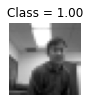

In [72]:
camera = iio.get_reader("<video0>")
time.sleep (1)
frame = camera.get_next_data()
xnijkV = np.array( [frame] )
camera.close()
xnijV = inputTrf (xnijkV)
xndV = xnijV.flatten (1,-1)
showSelfies (xnijV,cmap='gray',imageWidth=1) ; plt.title ("Class = {:.2f}".format (   model (xndV).detach().numpy() [0,0]   )) ;

#showSelfies (xnijkV,imageWidth=1) ; plt.title ("Class = {:.2f}".format (   model (xndV).detach().numpy() [0,0]   ))
